In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE,
  CC_DAYS_TO_ADD,
  TERMS_OF_PAYMENT_KEY  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
    AND ("2024-01-01" >=PAYMENT_DATE)
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df

,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,TERMS_OF_PAYMENT_KEY
0,2057199296,,,0000041400,2057199296,2023-08-25,ZF,01 - Invoice,2578.660000000,PD,CLEAR,2007-12-13,5.000000000,YS05
1,2057199296,,,0000041400,2057199296,2023-08-25,ZF,11 - Credit memo,-9.880000000,PD,CLEAR,2007-12-13,0E-9,YS05
2,2057199296,,,0000041400,2057199296,2023-08-24,ZF,11 - Credit memo,-45.690000000,PD,CLEAR,2007-12-13,0E-9,YS05
3,2057199296,,,0000041400,2057199296,2023-08-22,ZF,01 - Invoice,31.420000000,PD,CLEAR,2007-12-13,5.000000000,YS05
4,2057199296,,,0000041400,2057199296,2023-08-23,ZF,01 - Invoice,199.940000000,PD,CLEAR,2007-12-13,5.000000000,YS05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50487406,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2022-04-27,DH,16 - Payment difference,-60.940000000,Z2140,CLEAR,2023-12-22,0E-9,
50487407,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2022-08-12,DH,16 - Payment difference,-9942.640000000,Z2140,CLEAR,2023-12-22,0E-9,
50487408,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2022-08-09,DH,16 - Payment difference,-4.330000000,Z2140,CLEAR,2023-12-22,0E-9,
50487409,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2022-07-15,DH,16 - Payment difference,-18.900000000,Z2140,CLEAR,2023-12-22,0E-9,


In [7]:
df=df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
df['CC_DAYS_TO_ADD']=df['CC_DAYS_TO_ADD'].apply(lambda x: float(x))
df['AMOUNT_IN_LOCAL_CURRENCY']=df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
# df.reset_index(inplace = True)


In [8]:
def calc_WAPD1(df_1):
    df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
    df_1['DOCUMENT_DATE_IN_DOCUMENT']=pd.to_datetime(df_1['DOCUMENT_DATE_IN_DOCUMENT'])
    WAPD_new = pd.Series([])
    for index, row in df_1.iterrows():
        start_date= row['PAYMENT_DATE']
        end_date = row['90_days_ago']
        try:
            ninety_day_range = df_1.query('@start_date >= DOCUMENT_DATE_IN_DOCUMENT   >= @end_date')
            WAPD= ninety_day_range['Weighted Invoice Value'].sum() / ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
            WAPD_new[index]=WAPD
        except:
            print('no PAYMENT_DATE')
            WAPD_new[index]=0
    df_1.insert(16, "WAPD", WAPD_new)
    return df_1

In [9]:
def calc_WAPD(df_1):
    try:
        df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
        df_1['DOCUMENT_DATE_IN_DOCUMENT']=pd.to_datetime(df_1['DOCUMENT_DATE_IN_DOCUMENT'])
        # WAPD_new = pd.Series([])
        start_date= df_1['PAYMENT_DATE']
        end_date = df_1['90_days_ago']
        ninety_day_range = df_1.query('@start_date >= DOCUMENT_DATE_IN_DOCUMENT   >= @end_date')
        # print(ninety_day_range)
        df_1['WAPD']= ninety_day_range['Weighted Invoice Value'].sum() / ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
    except:
        print('no PAYMENT_DATE')
    
    return df_1

In [22]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    
    CUSTOMER_df.reset_index(inplace = True)
    # print(CUSTOMER_df)
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD1(CUSTOMER_df)
    CUSTOMER_df = final_dataFram(CUSTOMER_df)
    return CUSTOMER_df

In [11]:
# Returns a tuple of DataFrames sorted by DSO term

def get_terms(ENTERPRISE_ACCOUNT_NO):
    return_list = []
    
    terms_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    
    # terms_df.reset_index(inplace = True)
    terms_list = terms_df['CC_DAYS_TO_ADD'].unique()
    print(terms_list)
    
    # for dso_term in terms_list:
    #     name = str(dso_term)+"_term"
    #     name = terms_df.query('CC_DAYS_TO_ADD ==@dso_term')
    #     return_list.append(name)
    
    return None
 



In [12]:
def search_EAN(term,EAN):
    print(term)
    CUSTOMER_df=df.query('ENTERPRISE_ACCOUNT_NO == @EAN')
    print("Before\n",CUSTOMER_df)
    CUSTOMER_df=CUSTOMER_df.query('CC_DAYS_TO_ADD == @term')
    print("AFTER\n",CUSTOMER_df)
    CUSTOMER_df.reset_index(inplace = True)
   
    # CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    
    
    
    return CUSTOMER_df

In [13]:
def final_dataFram(toFix_df):
    toFix_df['month'] = toFix_df['PAYMENT_DATE'].dt.strftime('%b')
    df_final = pd.DataFrame({'Year': toFix_df.PAYMENT_DATE.dt.year,
                   'Month': toFix_df.month,
                   'CREDIT_CONTROL_AREA': toFix_df.CREDIT_CONTROL_AREA,
                   'WAPD':toFix_df.WAPD,
                    "CC_DAYS_TO_ADD":toFix_df.CC_DAYS_TO_ADD})
    dfff = (
        df_final
        .filter(["Year", "Month","CREDIT_CONTROL_AREA","WAPD","CC_DAYS_TO_ADD"])
        .groupby(['Year','Month','CREDIT_CONTROL_AREA',"CC_DAYS_TO_ADD"])
        .agg({'WAPD' : ['mean']})
        .sort_values(['Year',"Month","CC_DAYS_TO_ADD"])
        .reset_index()
    )
    dfff.columns = ['Year','Month', 'CREDIT_CONTROL_AREA','CC_DAYS_TO_ADD',"WAPD"]
    get_graph(dfff)
    return dfff
    

In [14]:
def get_graph(finished_df):
    dff = pd.DataFrame(
        dict(
            year=finished_df.Year.values ,
            month=finished_df.Month.values,
            CCA= finished_df.CREDIT_CONTROL_AREA.values,
            WAPD=finished_df.WAPD.values,
            dso_term = finished_df.CC_DAYS_TO_ADD.values
        )
    )

    fig = go.Figure()
    # fig = make_subplots(1,1)

    fig.update_layout(
        template="none",
        xaxis=dict(title_text="Year"),
        yaxis=dict(title_text="WAPD"),
        barmode="group",
    )

    colors = ["#456e73","#2A66DE", "#FFC32B","#457353"]

    for r, c in zip(dff.CCA.unique(), colors):
        plot_df = dff[dff.CCA == r]
        fig.add_trace(go.Bar(x=[plot_df.year, plot_df.month], y=plot_df.WAPD, name=r, marker_color=c))


    fig.add_trace(go.Scatter(x= [dff.year, dff.month], y=dff.dso_term, mode = 'lines',name = "DSO Term"))


    # fig.plot(fi.CC_DAYS_TO_ADD, c = "y", label = "DSO Term",zorder=10)
    fig.update_layout(title='WAPD')
    fig.show()

# **********************************************************************************************************

# Visualization

## Customer

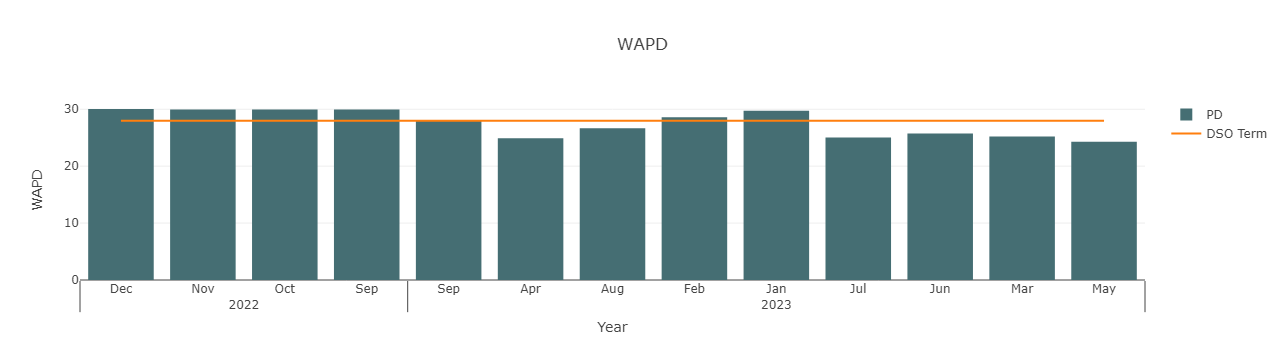

In [23]:
customer = "2057194397"
t = search_customer(customer)

In [24]:
t

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD
0,2022,Dec,PD,28.0000,30.0434
1,2022,Nov,PD,28.0000,29.9682
2,2022,Oct,PD,28.0000,29.9637
3,2022,Sep,PD,28.0000,29.9744
4,2023,Apr,PD,28.0000,24.8993
5,2023,Aug,PD,28.0000,26.6483
6,2023,Feb,PD,28.0000,28.5953
7,2023,Jan,PD,28.0000,29.7159
8,2023,Jul,PD,28.0000,25.0257
9,2023,Jun,PD,28.0000,25.7423


In [16]:
t

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD
0,2022,Dec,PD,28.0000,30.0434
1,2022,Nov,PD,28.0000,29.9682
2,2022,Oct,PD,28.0000,29.9637
3,2022,Sep,PD,28.0000,29.9744
4,2023,Apr,PD,28.0000,24.8993
5,2023,Aug,PD,28.0000,26.6483
6,2023,Feb,PD,28.0000,28.5953
7,2023,Jan,PD,28.0000,29.7159
8,2023,Jul,PD,28.0000,25.0257
9,2023,Jun,PD,28.0000,25.7423


In [ ]:
fail

## EAN

In [17]:
EAN = "7100007382"
get_terms(EAN)
# DSO terms are printed below

[ 15.  65.  60.  75.  90.  30.  32.  29.  31.   7.  35.  26.  59.  61.
  33. 120.   0.  34.  40.  27.  28.  37.  39.  36.  10.  38.   5.   8.]


In [18]:
term = 15

In [19]:
fi=search_EAN(term,EAN)

15
Before
          CUSTOMER_NUMBER ENTERPRISE_ACCOUNT_NO ENTERPRISE_ACCOUNT_NAME  \
1512589       4400100370            7100007382        7100007382 - CVS   
1517031       4400100370            7100007382        7100007382 - CVS   
1789699       4400100370            7100007382        7100007382 - CVS   
1789700       4400100370            7100007382        7100007382 - CVS   
1789701       4400100370            7100007382        7100007382 - CVS   
...                  ...                   ...                     ...   
50482169      2057199509            7100007382        7100007382 - CVS   
50483294      2057199227            7100007382        7100007382 - CVS   
50483295      2057199227            7100007382        7100007382 - CVS   
50483296      2057199498            7100007382        7100007382 - CVS   
50485598      2057199509            7100007382        7100007382 - CVS   

         NATIONAL_ACCOUNT       PAYER DOCUMENT_DATE_IN_DOCUMENT DOCUMENT_TYPE  \
1512589        0000

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/var/tmp/ipykernel_4072/322399916.py", line 4, in calc_WAPD
    df_1['DOCUMENT_DATE_IN_DOCUMENT']=pd.to_datetime(df_1['DOCUMENT_DATE_IN_DOCUMENT'])
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/tools/datetimes.py", line 885, in to_datetime
    result = arg.map(cache_array)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/series.py", line 4161, in map
    new_values = super()._map_values(arg, na_action=na_action)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/base.py", line 842, in _map_values
    indexer = mapper.index.get_indexer(values)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3437, in get_indexer
    target = self._maybe_cast_listlike_indexer(target)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 5708, in _maybe_cast_listlike_indexer
    return ensure_index(target)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/


KeyboardInterrupt



In [ ]:
final_dataFram(fi)


## National Account